# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [72]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [73]:
n_train = X_train.shape[0]

n_validation = X_valid.shape[0]

n_test = X_test.shape[0]

image_shape = [32,32,3]

n_classes = 43

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43


### Dataset Exploratory Visualization

10


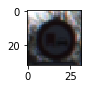

In [74]:
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

Dataset Exploratory Visualization


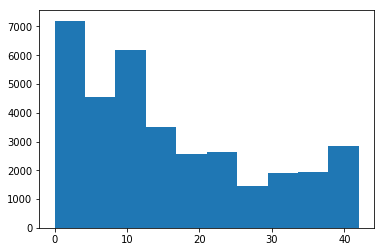

In [75]:
print("Dataset Exploratory Visualization")
plt.figure()
plt.hist(y_train)
plt.savefig('examples/plot_hist.png')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Model Architecture

### Preprocessing and Augmentation 

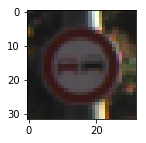

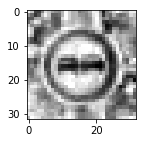

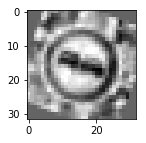

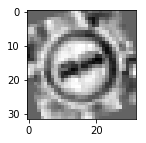

In [76]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Convert the data to Grayscale
# Apply Contrast Limited Adaptive Histogram Equalization.
# Apply Input Data Normalization
def preprocess(x):
    n = len(x)
    x_gray = np.zeros((n,32,32),dtype=np.uint8)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    for i in range(n):
        x_gray[i] = cv2.cvtColor(x[i], cv2.COLOR_RGB2GRAY)
        x_gray[i] = clahe.apply(x_gray[i])
        
    x_gray = x_gray.reshape(n,32,32,1)
    x_gray = ((x_gray/255.0) - 0.5)
    
    return x_gray

# Create rotated images and add them to the training set
def transform_data(x,y, index):
    n = len(x)

    x_trans_1 = np.zeros((n,32,32),dtype=np.float32)
    x_trans_2 = np.zeros((n,32,32),dtype=np.float32)
    
    M1 = cv2.getRotationMatrix2D((16,16),20,1)
    
    M2 = cv2.getRotationMatrix2D((16,16),-20,1)
    
    for i in range(n):
        x_trans_1[i] = cv2.warpAffine(x[i],M1,(32,32))
        x_trans_2[i] = cv2.warpAffine(x[i],M2,(32,32))
        
    image_rotate_ccw_20 = x_trans_1[index].squeeze()
    image_rotate_cw_20 = x_trans_2[index].squeeze()
    plt.figure(figsize=(2,2))
    plt.imshow(image_rotate_cw_20,cmap='gray')
    plt.savefig('examples/dataset_ro_after_cw.png')
    plt.figure(figsize=(2,2))
    plt.imshow(image_rotate_ccw_20,cmap='gray')
    plt.savefig('examples/dataset_ro_after_ccw.png')

    x_trans_1 = x_trans_1.reshape(n,32,32,1)
    x_trans_2 = x_trans_2.reshape(n,32,32,1)
    
    x_output = np.concatenate((np.concatenate((x,x_trans_1), axis = 0),x_trans_2), axis = 0)
    y_output = np.append(np.append(y,y),y)

    return (x_output,y_output)

# Shuffle data for better reliability
X_train, y_train = shuffle(X_train, y_train)

X_train_pre = preprocess(X_train)
X_valid_pre = preprocess(X_valid)
X_test_pre = preprocess(X_test)

index = random.randint(0, len(X_train))
image_before = X_train[index].squeeze()
image_after = X_train_pre[index].squeeze()
plt.figure(figsize=(2,2))
plt.imshow(image_before)
plt.savefig('examples/dataset_ex_before.png')
plt.figure(figsize=(2,2))
plt.imshow(image_after,cmap='gray')
plt.savefig('examples/dataset_ex_After.png')

X_train_pre, y_train_pre = transform_data(X_train_pre, y_train, index)


In [99]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 150

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### LeNet Function

In [100]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x10.
    WC1 = tf.Variable(tf.truncated_normal(shape = (5,5,1,10), mean = mu, stddev = sigma))
    BC1 = tf.Variable(tf.zeros([10]))
    strides = [1,1,1,1]
    padding = 'VALID'
    conv1 = tf.nn.conv2d(x,WC1,strides,padding)
    conv1 = tf.nn.bias_add(conv1,BC1, name = 'Conv_1')
    
    # TODO: Pooling. Input = 28x28x10. Output = 14x14x10.
    conv1 = tf.nn.max_pool(conv1, ksize = [1,2,2,1], strides = [1,2,2,1] , padding = 'SAME')
    
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # TODO: Layer 2: Convolutional. Output = 10x10x22.
    WC2 = tf.Variable(tf.truncated_normal(shape = (5,5,10,22), mean = mu, stddev = sigma))
    BC2 = tf.Variable(tf.zeros([22]))
    strides = [1,1,1,1]
    padding = 'VALID'
    conv2 = tf.nn.conv2d(conv1, WC2, strides, padding)
    conv2 = tf.nn.bias_add(conv2, BC2, name = 'Conv_2')
    
    # TODO: Pooling. Input = 10x10x22. Output = 5x5x22.
    conv2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Flatten. Input = 5x5x22. Output = 550.
    conv_output = tf.contrib.layers.flatten(conv2)
    
    # TODO: Layer 3: Fully Connected. Input = 550. Output = 350.
    WF1 = tf.Variable(tf.truncated_normal(shape = (550,350), mean = mu, stddev = sigma))
    BF1 = tf.Variable(tf.zeros([350]))
    FC1 = tf.matmul(conv_output,WF1)
    FC1 = tf.add(FC1,BF1, name = 'FC1')
    
    # TODO: Activation.
    FC1 = tf.nn.relu(FC1)
    FC1 = tf.nn.dropout(FC1,0.8)
    
    # TODO: Layer 5: Fully Connected. Input = 350. Output = 43.
    WF2 = tf.Variable(tf.truncated_normal(shape = (350,43) , mean = mu, stddev = sigma))
    BF2 = tf.Variable(tf.zeros([43]))
    logits = tf.add(tf.matmul(FC1,WF2),BF2)
    
    return logits

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

# Training Pipeline

### Load and Output the Images

In [101]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Model Optimization

In [102]:
rate = 0.0052

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [103]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation,accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x)) 
    return (total_loss/ num_examples) , (total_accuracy / num_examples)

### Train The Model

Training...

EPOCH 1 ...
Validation Accuracy = 0.948 Training Accuracy = 0.971

EPOCH 2 ...
Validation Accuracy = 0.950 Training Accuracy = 0.982

EPOCH 3 ...
Validation Accuracy = 0.955 Training Accuracy = 0.984

EPOCH 4 ...
Validation Accuracy = 0.946 Training Accuracy = 0.985

EPOCH 5 ...
Validation Accuracy = 0.963 Training Accuracy = 0.983

EPOCH 6 ...
Validation Accuracy = 0.950 Training Accuracy = 0.987

EPOCH 7 ...
Validation Accuracy = 0.959 Training Accuracy = 0.987

EPOCH 8 ...
Validation Accuracy = 0.960 Training Accuracy = 0.990

EPOCH 9 ...
Validation Accuracy = 0.958 Training Accuracy = 0.990

EPOCH 10 ...
Validation Accuracy = 0.958 Training Accuracy = 0.990

Model saved


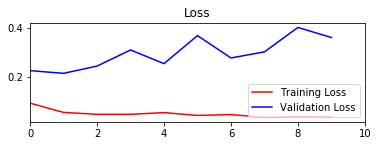

In [104]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_pre)
    
    valid_loss_history = []
    train_loss_history = []
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_pre, y_train_pre = shuffle(X_train_pre, y_train_pre)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_pre[offset:end], y_train_pre[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_loss, validation_accuracy = evaluate(X_valid_pre, y_valid)
        valid_loss_history.append(validation_loss)
        train_loss, train_accuracy = evaluate(X_train_pre, y_train_pre)
        train_loss_history.append(train_loss)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f} Training Accuracy = {:.3f}".format(validation_accuracy,train_accuracy))
        print()
        
    loss_plot = plt.subplot(2,1,1)
    loss_plot.set_title('Loss')
    loss_plot.plot(train_loss_history, 'r', label='Training Loss')
    loss_plot.plot(valid_loss_history, 'b', label='Validation Loss')
    loss_plot.set_xlim([0, EPOCHS])
    loss_plot.legend(loc=4)

    saver.save(sess, './traffic_sign')
    print("Model saved")

### Predict the Sign Type for Each Image

In [105]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_loss, test_accuracy = evaluate(X_test_pre, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.942


### Analyze Performance

1.0


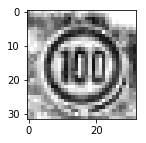

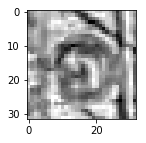

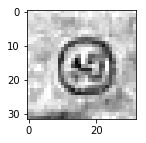

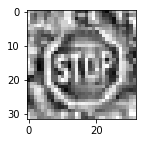

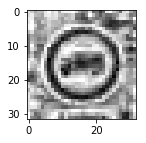

In [114]:
### Calculate the accuracy for these 5 new images. 
import cv2
import os, random

test_DE_dir = "GTSRB_Training/Final_Training/Images/"

X_DE_test = []
Y_DE_test = []

for index in range(5):
    foldername = random.choice(os.listdir(test_DE_dir))
    folder_path = os.path.join(test_DE_dir, foldername)
    filename = random.choice(os.listdir(folder_path))
    img = cv2.imread(os.path.join(folder_path,filename))
    if img is not None:
        img = cv2.resize(img, (32, 32))
        X_DE_test.append(img)
        class_id = foldername.replace("0","");
        if(class_id == ""):
            class_id = "0"
        Y_DE_test.append(int(class_id))

X_DE_test = preprocess(X_DE_test)

for index in range(5):
    img = X_DE_test[index].squeeze()
    plt.figure(figsize=(2,2))
    plt.imshow(img,cmap='gray')
    f_path = "examples/DE_image" + str(index) + ".png"
    plt.savefig(f_path)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_loss, test_accuracy = evaluate(X_DE_test, Y_DE_test)
    print(test_accuracy)
    

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

In [115]:
import pandas as pd
signnames = pd.read_csv('signnames.csv')

#test
print(signnames.iat[2,1])

Speed limit (50km/h)


In [116]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
softmax = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_loss, test_accuracy = evaluate(X_DE_test, Y_DE_test)
    
    result = sess.run(softmax, feed_dict = {x : X_DE_test})
    
    k_var = 5
    
    values, indices = tf.nn.top_k(result, k_var)

    probabilities = sess.run(values)
    predictions = sess.run(indices)
    
    for test_img in range(5):
        print(str(test_img+1) + ") Real: " + signnames.iat[Y_DE_test[test_img],1]," Pred: " + signnames.iat[predictions[test_img, 0],1])
        print()
        for prob in range(k_var):
            print("%0.2f" %probabilities[test_img,prob]," ", signnames.iat[predictions[test_img, prob],1])
        print()

1) Real: Speed limit (100km/h)  Pred: Speed limit (100km/h)

1.00   Speed limit (100km/h)
0.00   Speed limit (80km/h)
0.00   Speed limit (120km/h)
0.00   Speed limit (30km/h)
0.00   Roundabout mandatory

2) Real: Turn left ahead  Pred: Turn left ahead

1.00   Turn left ahead
0.00   Keep right
0.00   General caution
0.00   Traffic signals
0.00   Speed limit (50km/h)

3) Real: Speed limit (60km/h)  Pred: Speed limit (60km/h)

1.00   Speed limit (60km/h)
0.00   Speed limit (80km/h)
0.00   Speed limit (50km/h)
0.00   Speed limit (30km/h)
0.00   Turn left ahead

4) Real: Stop  Pred: Stop

1.00   Stop
0.00   Ahead only
0.00   Speed limit (120km/h)
0.00   Speed limit (80km/h)
0.00   Roundabout mandatory

5) Real: Vehicles over 3.5 metric tons prohibited  Pred: Vehicles over 3.5 metric tons prohibited

1.00   Vehicles over 3.5 metric tons prohibited
0.00   No passing
0.00   No vehicles
0.00   Speed limit (100km/h)
0.00   Speed limit (30km/h)



### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


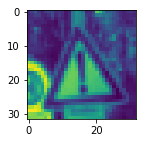

In [117]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
        
        plt.savefig('examples/visualization.png',bbox_inches='tight')
            

test_DE_dir = "GTSRB_Training/Final_Training/Images/"
foldername = random.choice(os.listdir(test_DE_dir))
folder_path = os.path.join(test_DE_dir, foldername)
filename = random.choice(os.listdir(folder_path))
img = cv2.imread(os.path.join(folder_path,filename))
if img is not None:
    img = cv2.resize(img, (32, 32))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.reshape(1,32,32,1)
    img = ((img/255.0) - 0.5)
    img = img.astype(np.float32, copy=False)
    plt.figure(figsize=(2,2))
    plt.imshow(img.squeeze())
    plt.savefig('examples/visualization_image.png')

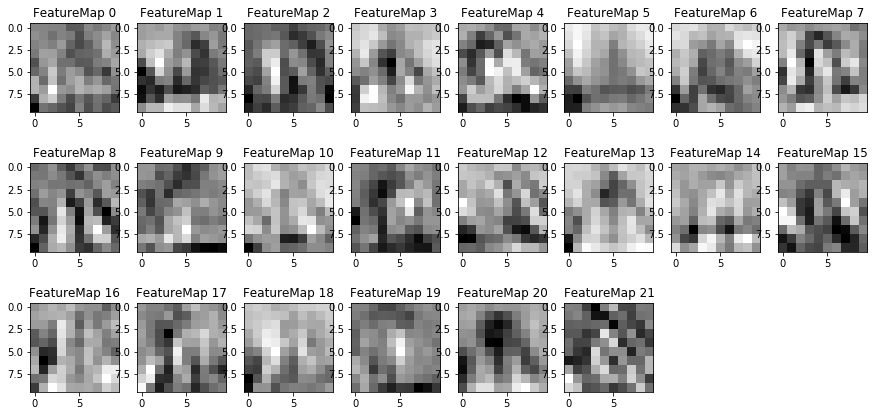

In [118]:
if img is not None:    
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('traffic_sign.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('.'))
        Conv1 = tf.get_default_graph().get_tensor_by_name("Conv_1:0")
        outputFeatureMap(img,Conv1)
        Conv2 = tf.get_default_graph().get_tensor_by_name("Conv_2:0")
        outputFeatureMap(img,Conv2)